In [1]:
import pickle
import os

FOLDER = os.getcwd() + "/4_pts_blurry"

with open(FOLDER+'/ori.pkl', 'rb') as file:   
    ori = pickle.load(file)
with open(FOLDER+'/mask.pkl', 'rb') as file:   
    mask = pickle.load(file)
with open(FOLDER+'/out.pkl', 'rb') as file:   
    out = pickle.load(file)
with open(FOLDER+'/psf.pkl', 'rb') as file:   
    original_psf = pickle.load(file)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import math
import numpy as np
import random
import time
from SyMBac.PSF import PSF_generator

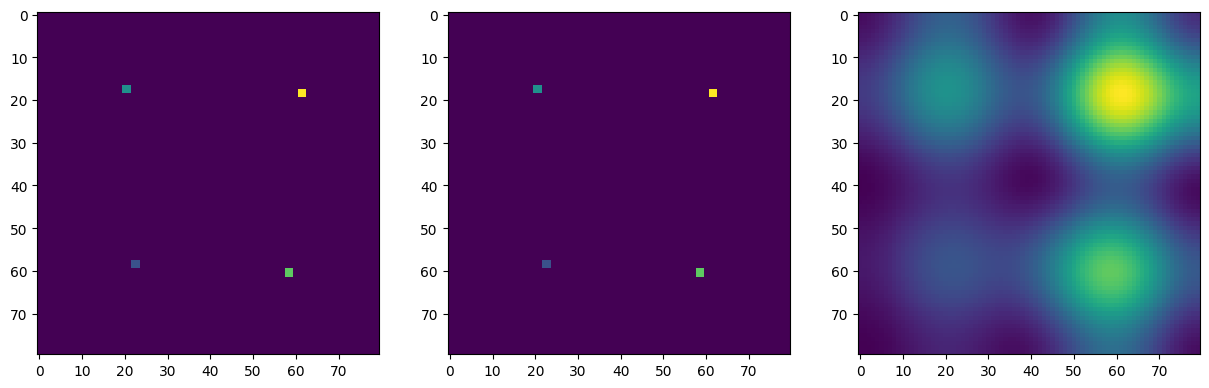

In [3]:
f, axarr = plt.subplots(1,3)
axarr[0].imshow(ori)
axarr[1].imshow(mask)
axarr[2].imshow(out)
plt.show()

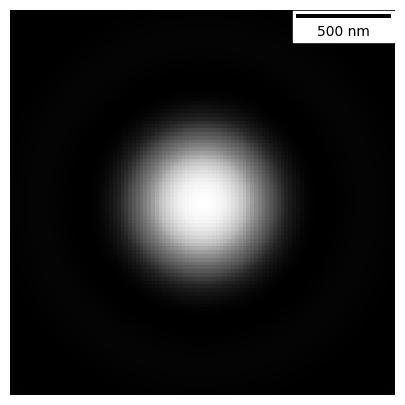

[[0.00414948 0.00415171 0.00409537 ... 0.00409537 0.00415171 0.00414948]
 [0.00415171 0.00409358 0.00397612 ... 0.00397612 0.00409358 0.00415171]
 [0.00409537 0.00397612 0.00379854 ... 0.00379854 0.00397612 0.00409537]
 ...
 [0.00409537 0.00397612 0.00379854 ... 0.00379854 0.00397612 0.00409537]
 [0.00415171 0.00409358 0.00397612 ... 0.00397612 0.00409358 0.00415171]
 [0.00414948 0.00415171 0.00409537 ... 0.00409537 0.00415171 0.00414948]]


/home/boomalope/symbac/symbac/lib/python3.8/site-packages/SyMBac/PSF.py:178: RuntimeWarning: invalid value encountered in divide
  PSF = (2 * jv(1, rr) / (rr)) ** 2


In [4]:
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.0, 
    n = 1.4, 
    resize_amount = 1, 
    pix_mic_conv = 0.02, 
    apo_sigma = 8, 
    mode="simple fluo", 
    condenser = "Ph3",
    offset = 0
)
my_kernel.calculate_PSF()
my_kernel.plot_PSF()
psf = my_kernel.get_fluorescence_kernel(my_kernel.wavelength,my_kernel.NA,my_kernel.n,my_kernel.radius,my_kernel.scale)
print(psf)

In [ ]:
#Get all sourcePts
#Final all non zero mask points

sourcePts = []

(maskWidth, maskHeight) = mask.shape

for i in range(maskWidth):
    for j in range(maskHeight):
        if mask[i,j] != 0:
            sourcePts.append([i,j])
print(len(sourcePts))

#Take only a random subset of the sourcePts

random.shuffle(sourcePts)
sourcePts = sourcePts[:]

print(sourcePts)

#Assemble the matrix
additionalPts = []
for _ in range(0):
    x = random.randint(0,len(out)-1)
    y = random.randint(0,len(out[0])-1)
    additionalPts.append([x,y])

#Include points along the edge
for i in range(len(out)):
    additionalPts.append([i,0])
    additionalPts.append([i,len(out[0])-1])
for i in range(len(out[0])):
    additionalPts.append([0,i])
    additionalPts.append([len(out)-1,i])

print(len(additionalPts))

In [ ]:
def AverageFilter(img, x, y):
    sz = [ -2, -1, 0 , 1, 2]
    total = 0
    for i in sz:
        for j in sz:
            if x+i >= 0 and x+i < len(img) and y+j >= 0 and y+j < len(img[0]):
                total += img[x+i][y+j]
    total/=len(sz)*len(sz)
    return total

def euclideanDistance(x,y):
    return ((x[0]-y[0])**2 + (x[1]-y[1])**2)**0.5

def getPSF(origin,target,psf):
    assert(len(psf)%2 == 1) and (len(psf[0])%2 == 1)
    centre = [int(len(psf)/2),int(len(psf[0])/2)]
    shifted_target = [target[0]-origin[0]+centre[0],target[1]-origin[1]+centre[1]]
    if (shifted_target[0] < 0 or shifted_target[0] >= len(psf)) or (shifted_target[1] < 0 or shifted_target[1] >= len(psf[0])):
        return 0
    else:
        return psf[shifted_target[0]][shifted_target[1]]